In [183]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb
import catboost as cb
from sklearn.model_selection import GridSearchCV
import shap
shap.initjs()

### 1. Считать в pandas.DataFrame любой источник данных: CSV, JSON, Excel-файл, HTML-таблицу и т.п.

In [184]:
df = pd.read_csv('../datasets/co2.csv')
df = df.drop(columns=['Make', 'Model'])
df= df[df['Fuel Type'] != 'N']

### 2. Датасет и подготовка данных:

In [185]:
df.head()

,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


Привести описание датасета.

<!DOCTYPE html>
<html lang="ru">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Описание признаков набора данных об автомобилях</title>
    <style>
        table {
            width: 100%;
            border-collapse: collapse;
        }
        th, td {
            border: 1px solid black;
            padding: 8px;
            text-align: left;
        }
        th {
            background-color: rgb(55, 55, 55);
            color: white;
        }
    </style>
</head>
<body>
    <h2>Описание признаков набора данных об автомобилях</h2>
    <table>
        <thead>
            <tr>
                <th>Признак</th>
                <th>Описание</th>
                <th>Тип данных</th>
            </tr>
        </thead>
        <tbody>
            <tr>
                <td>Vehicle Class</td>
                <td>Класс транспортного средства (например, COMPACT, SUV - SMALL)</td>
                <td>string</td>
            </tr>
            <tr>
                <td>Engine Size(L)</td>
                <td>Объем двигателя в литрах</td>
                <td>float</td>
            </tr>
            <tr>
                <td>Cylinders</td>
                <td>Количество цилиндров в двигателе</td>
                <td>int</td>
            </tr>
            <tr>
                <td>Transmission</td>
                <td>Тип трансмиссии (например, AS5 - автоматическая 5-ступенчатая, M6 - механическая 6-ступенчатая)</td>
                <td>string</td>
            </tr>
            <tr>
                <td>Fuel Type</td>
                <td>Тип топлива (Z - вероятно, означает бензин)</td>
                <td>string</td>
            </tr>
            <tr>
                <td>Fuel Consumption City (L/100 km)</td>
                <td>Расход топлива в городском цикле (литров на 100 км)</td>
                <td>float</td>
            </tr>
            <tr>
                <td>Fuel Consumption Hwy (L/100 km)</td>
                <td>Расход топлива на трассе (литров на 100 км)</td>
                <td>float</td>
            </tr>
            <tr>
                <td>Fuel Consumption Comb (L/100 km)</td>
                <td>Комбинированный расход топлива (литров на 100 км)</td>
                <td>float</td>
            </tr>
            <tr>
                <td>Fuel Consumption Comb (mpg)</td>
                <td>Комбинированный расход топлива в милях на галлон</td>
                <td>int</td>
            </tr>
            <tr>
                <td>CO2 Emissions(g/km)</td>
                <td>Выбросы CO2 в граммах на километр</td>
                <td>int</td>
            </tr>
        </tbody>
    </table>
</body>
</html>

Осуществить предобработку данных (избавиться от null, убрать некоторые признаки и т.п.) - "подчистить данные".

In [186]:
df = df.dropna()
cat_features = df.select_dtypes(include=['object']).columns.tolist()
quant_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'Fuel Type' in quant_features:
    quant_features.remove('Fuel Type')
le = LabelEncoder()
df['Fuel Type'] = le.fit_transform(df['Fuel Type'])
target = 'Fuel Type'

Нормализовать численные данные.

In [187]:
scaler = StandardScaler()
df[quant_features] = scaler.fit_transform(df[quant_features])

Разбить выборку на обучающую и тестовую.

In [188]:
le = LabelEncoder()
encoder = OneHotEncoder(sparse_output=False) 
data_encoded = df.copy()
categorical_cols = ['Transmission', 'Vehicle Class']
encoded_data = encoder.fit_transform(df[categorical_cols])
encoded_df = pd.DataFrame(
    encoded_data,
    columns=encoder.get_feature_names_out(categorical_cols),
    index=df.index
)

data_encoded = pd.concat([df.drop(categorical_cols, axis=1), encoded_df], axis=1)
data_encoded['Fuel Type'] = le.fit_transform(df['Fuel Type'])

In [189]:
data_raw_cat = df.copy()

# Разделение на обучающую и тестовую выборки
X_encoded = data_encoded.drop(target, axis=1)
y = data_encoded[target]
X_raw_cat = data_raw_cat.drop(target, axis=1)

X_train_enc, X_test_enc, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
X_train_raw, X_test_raw, _, _ = train_test_split(X_raw_cat, y, test_size=0.2, random_state=42)

### 3. Для каждого из классификаторов (*AdaBoost*, *GradientBoostingClassifier*, *XGBoost*, *CatBoost*)

С использованием GridSearchCV/grid_search осуществить подбор гиперпараметра модели, использовать выборки с закодированными категориальными признаками.

Вывести метрики на тестовом наборе (как минимум classification_report, другие по желанию).

#### AdaBoost

In [190]:
ada = AdaBoostClassifier()
params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0]
}
ada_gs = GridSearchCV(ada, params, cv=3, n_jobs=-1)
ada_gs.fit(X_train_enc, y_train)
best_ada = ada_gs.best_estimator_
y_pred = best_ada.predict(X_test_enc)
print("AdaBoost")
print(classification_report(y_test, y_pred))

AdaBoost
              precision    recall  f1-score   support

           0       0.89      0.21      0.33        39
           1       0.49      0.54      0.52        74
           2       0.74      0.88      0.80       725
           3       0.81      0.66      0.73       639

    accuracy                           0.75      1477
   macro avg       0.73      0.57      0.59      1477
weighted avg       0.76      0.75      0.74      1477



#### GradientBoostingClassifier

In [191]:
gb = GradientBoostingClassifier()
params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5]
}
gb_gs = GridSearchCV(gb, params, cv=3, n_jobs=-1)
gb_gs.fit(X_train_enc, y_train)
best_gb = gb_gs.best_estimator_
y_pred = best_gb.predict(X_test_enc)
print("GradientBoosting")
print(classification_report(y_test, y_pred))

GradientBoosting
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        39
           1       1.00      1.00      1.00        74
           2       0.96      0.97      0.96       725
           3       0.97      0.95      0.96       639

    accuracy                           0.96      1477
   macro avg       0.98      0.96      0.97      1477
weighted avg       0.96      0.96      0.96      1477



#### XGBoost (с закодированными признаками)

In [192]:
xgb_enc = xgb.XGBClassifier()
params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0, 0.1]
}
xgb_gs = GridSearchCV(xgb_enc, params, cv=3, n_jobs=-1)
xgb_gs.fit(X_train_enc, y_train)
best_xgb_enc = xgb_gs.best_estimator_
y_pred = best_xgb_enc.predict(X_test_enc)
print("XGBoost (encoded)")
print(classification_report(y_test, y_pred))

XGBoost (encoded)
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        39
           1       1.00      0.99      0.99        74
           2       0.94      0.96      0.95       725
           3       0.95      0.93      0.94       639

    accuracy                           0.95      1477
   macro avg       0.97      0.96      0.96      1477
weighted avg       0.95      0.95      0.95      1477



#### XGBoost (с категориальными признаками "как есть")

In [193]:
for col in categorical_cols:
    X_train_raw[col] = X_train_raw[col].astype('category')
    X_test_raw[col] = X_test_raw[col].astype('category')
    
best_xgb_raw = xgb.XGBClassifier(**xgb_gs.best_params_, enable_categorical=True)
best_xgb_raw.fit(X_train_raw, y_train)
y_pred = best_xgb_raw.predict(X_test_raw)
print("XGBoost (raw cat)")
print(classification_report(y_test, y_pred))

XGBoost (raw cat)
              precision    recall  f1-score   support

           0       0.97      0.92      0.95        39
           1       0.99      0.99      0.99        74
           2       0.83      0.88      0.86       725
           3       0.86      0.80      0.83       639

    accuracy                           0.85      1477
   macro avg       0.91      0.90      0.90      1477
weighted avg       0.85      0.85      0.85      1477



#### CatBoost (с закодированными признаками)

In [194]:
cb_enc = cb.CatBoostClassifier(verbose=0)
params = {
    'iterations': [100, 200],
    'learning_rate': [0.05, 0.1],
    'depth': [3, 5],
    'l2_leaf_reg': [1, 3]
}
cb_gs = GridSearchCV(cb_enc, params, cv=3, n_jobs=-1)
cb_gs.fit(X_train_enc, y_train)
best_cb_enc = cb_gs.best_estimator_
y_pred = best_cb_enc.predict(X_test_enc)
print("CatBoost (encoded)")
print(classification_report(y_test, y_pred))

CatBoost (encoded)
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        39
           1       1.00      1.00      1.00        74
           2       0.92      0.95      0.94       725
           3       0.94      0.91      0.93       639

    accuracy                           0.94      1477
   macro avg       0.97      0.95      0.96      1477
weighted avg       0.94      0.94      0.94      1477



#### CatBoost (с категориальными признаками "как есть")

In [195]:
cat_features = [col for col in cat_features if col in X_train_raw.columns]

# Инициализация и обучение CatBoost
best_cb_raw = cb.CatBoostClassifier(
    **cb_gs.best_params_,
    cat_features=cat_features,
    verbose=0
)

best_cb_raw.fit(X_train_raw, y_train)
y_pred = best_cb_raw.predict(X_test_raw)
print("\nCatBoost (raw cat):")
print(classification_report(y_test, y_pred))


CatBoost (raw cat):
              precision    recall  f1-score   support

           0       0.97      0.92      0.95        39
           1       1.00      1.00      1.00        74
           2       0.93      0.95      0.94       725
           3       0.94      0.92      0.93       639

    accuracy                           0.94      1477
   macro avg       0.96      0.95      0.95      1477
weighted avg       0.94      0.94      0.94      1477



Сравнить модели, выбрать лучшую.

1. AdaBoost:
- Accuracy: 0.75
- Macro avg F1-score: 0.59
- Weighted avg F1-score: 0.74

2. GradientBoosting:
- Accuracy: 0.96
- Macro avg F1-score: 0.97
- Weighted avg F1-score: 0.96

3. XGBoost (encoded):
- Accuracy: 0.95
- Macro avg F1-score: 0.96
- Weighted avg F1-score: 0.95

4. XGBoost (raw cat):
- Accuracy: 0.85
- Macro avg F1-score: 0.90
- Weighted avg F1-score: 0.85

5. CatBoost (encoded):
- Accuracy: 0.94
- Macro avg F1-score: 0.96
- Weighted avg F1-score: 0.94

6. CatBoost (raw cat):
- Accuracy: 0.94
- Macro avg F1-score: 0.95
- Weighted avg F1-score: 0.94


Вывод:
Модель GradientBoosting показывает наилучшие результаты по всем метрикам: точность (accuracy) 0.96, средняя F1-оценка (macro avg) 0.97 и взвешенная F1-оценка (weighted avg) 0.96. Это делает её лучшей среди представленных моделей.

In [196]:
# При попытке использовать SHAP для GradientBoosting, возникает ошибка 
# InvalidModelError: GradientBoostingClassifier is only supported for binary classification right now!
# Поэтому используем ближайшую по метрикам модель, XGBoost (encoded)
best_model  = best_xgb_enc


### 4. Важность признаков:

С использованием shap.TreeExplainer получить *SHAP* -значения для лучшей модели.

In [197]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_enc)

Построить график shap.plots.force для одного объекта выборки и для среза произвольного размера.

In [198]:
feature_indices = [0, 1, 2]
shap.plots.force(
    explainer.expected_value[0],
    shap_values[0][0, feature_indices],
    X_test_enc.iloc[0, feature_indices]
)

Построить график shap.plots.bar для одного объекта выборки.

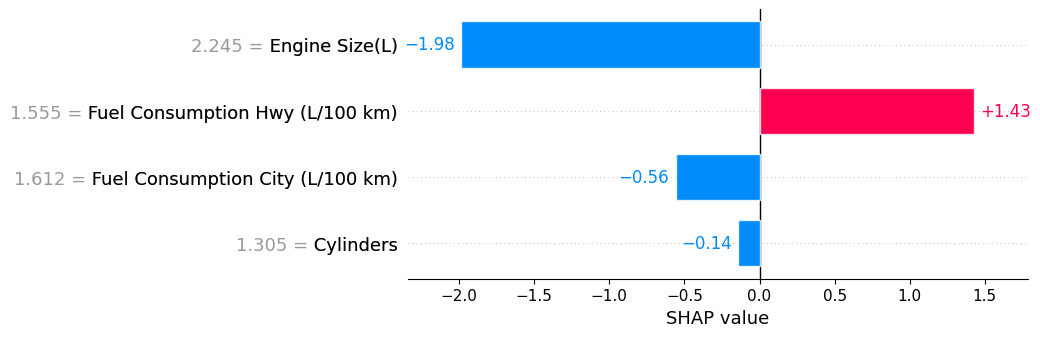

In [199]:
shap.plots.bar(shap.Explanation(values=shap_values[0][0,:], 
               base_values=explainer.expected_value[0], 
               data=X_test_enc.iloc[0,:]))

Построить график shap.plots.waterfall для одного объекта выборки.

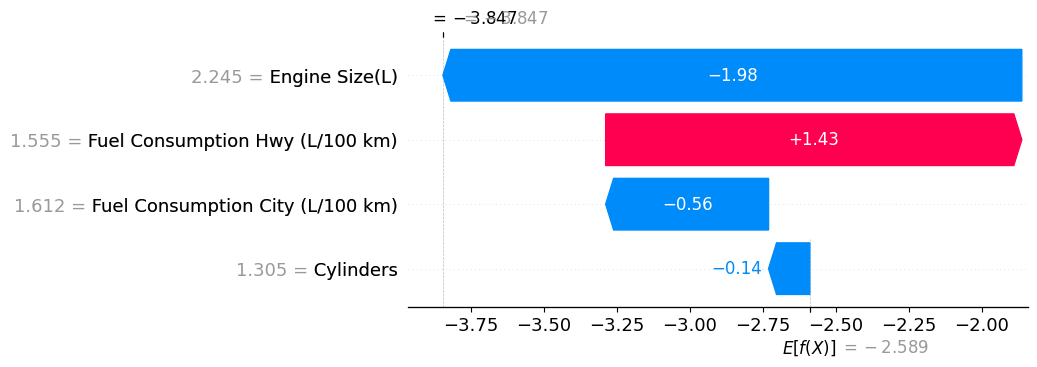

In [200]:
shap.plots.waterfall(shap.Explanation(values=shap_values[0][0,:], 
                     base_values=explainer.expected_value[0], 
                     data=X_test_enc.iloc[0,:]))

Построить 2 графика shap.plots.scatter для какого-нибудь признака. На одном раскрасить относительно себя, на втором – относительно другого признака.

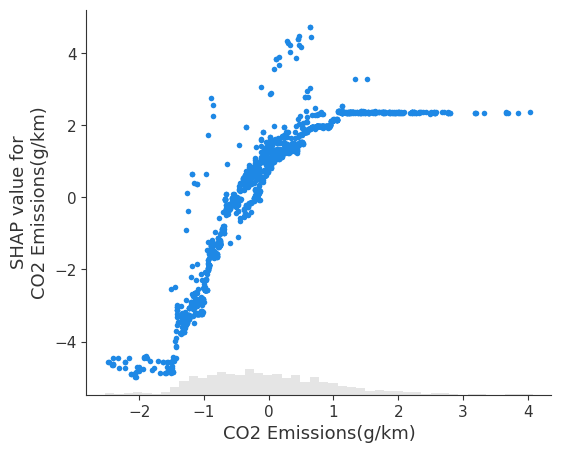

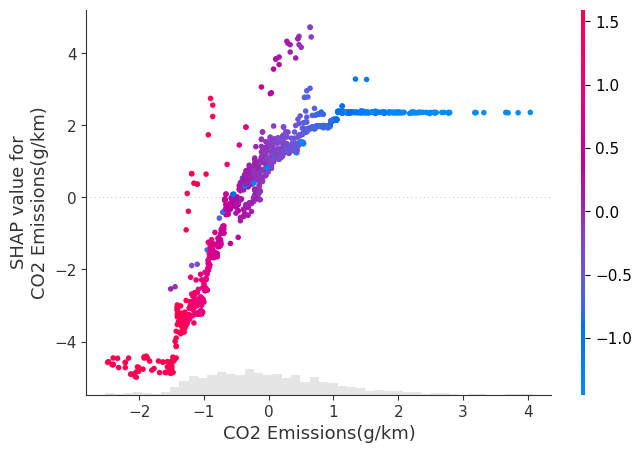

In [201]:
feature_names = X_test_enc.columns
annual_income_index = list(feature_names).index("CO2 Emissions(g/km)")
age_index = list(feature_names).index("Fuel Consumption Comb (mpg)")

class_idx = 0
shap_values_single_class = shap_values[:, :, class_idx]

shap_explanation = shap.Explanation(
    values=shap_values_single_class,
    base_values=explainer.expected_value[class_idx],
    data=X_test_enc.values,
    feature_names=X_test_enc.columns.tolist()
)

shap.plots.scatter(shap_explanation[:, annual_income_index])

shap.plots.scatter(
    shap_explanation[:, annual_income_index],
    color=X_test_raw["Fuel Consumption Comb (mpg)"].values
)

Построить график shap.plots.beeswarm для всех признаков.

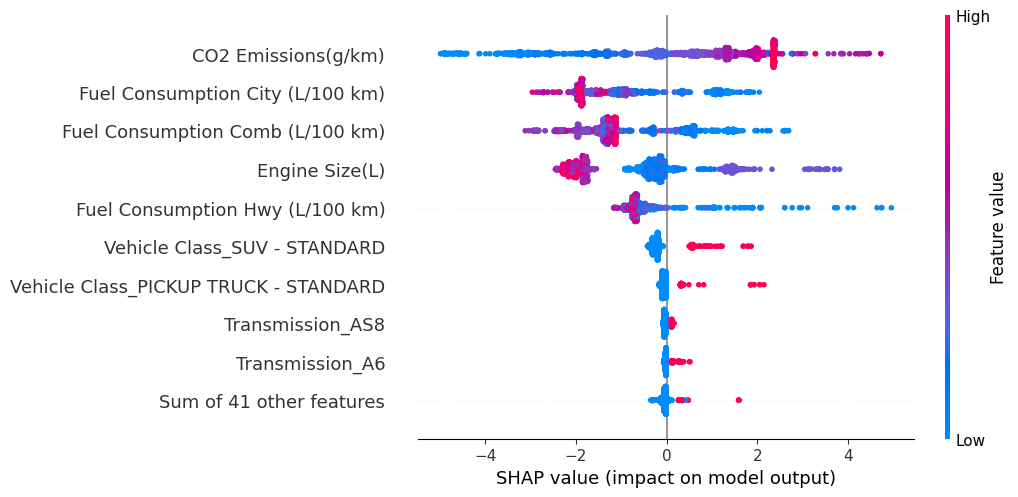

In [202]:
shap.plots.beeswarm(shap_explanation)

Построить график shap.plots.bar для всех признаков.

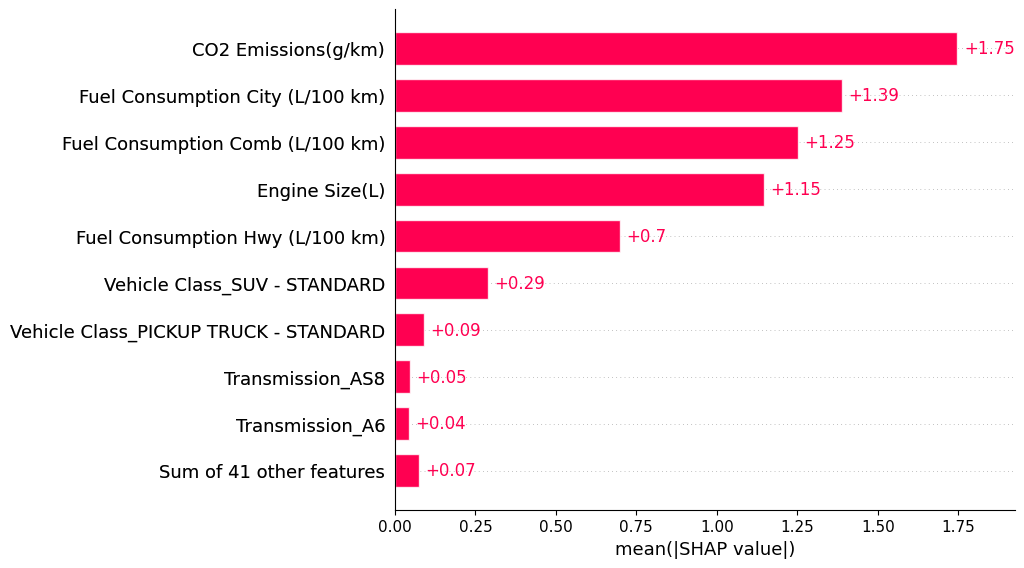

In [203]:
shap.plots.bar(shap_explanation)


На основании двух последних графиков и/или используя feature_importance отфильровать признаки (отразить сформулированные выводы в тексте), переобучить лучшую модель.

In [204]:
feature_importance = np.abs(shap_explanation.values).mean(axis=0)
important_features = X_test_enc.columns[feature_importance > np.quantile(feature_importance, 0.9)]
print(important_features)

Index(['Engine Size(L)', 'Fuel Consumption City (L/100 km)',
       'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)',
       'CO2 Emissions(g/km)'],
      dtype='object')


Топ-3 наиболее влиятельных признака:

- CO2 Emissions(g/km) - абсолютный лидер с SHAP-значением +1.75
- Fuel Consumption City (L/100 km) - второй по значимости (+1.39)
- Fuel Consumption Comb (L/100 km) - третий важный фактор (+1.25)

Обоснование выбора:
- Все признаки имеют SHAP-значение выше 0.7
- Включают 5 наиболее значимых факторов
- Исключены маловлиятельные признаки (SHAP < 0.5)


In [205]:
X_train_filtered = X_train_enc[important_features]
X_test_filtered = X_test_enc[important_features]
    
# Переобучаем модель
best_xgb_enc.fit(X_train_filtered, y_train)
y_pred_filtered = best_xgb_enc.predict(X_test_filtered)

print("XGBoost с отобранными признаками")
print(classification_report(y_test, y_pred_filtered))

XGBoost с отобранными признаками
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        39
           1       1.00      0.99      0.99        74
           2       0.89      0.90      0.89       725
           3       0.89      0.87      0.88       639

    accuracy                           0.90      1477
   macro avg       0.94      0.93      0.94      1477
weighted avg       0.90      0.90      0.90      1477



Сравнить метрики до и после фильтрации.


**Полная модель (50 признаков)**
- Accuracy: 0.95
- macro avg: 0.96
- F1-score (weighted avg): 0.95

Class-wise F1:
- Class 0: 0.97
- Class 1: 0.99
- Class 2: 0.95
- Class 3: 0.94

**Модель с отобранными признаками (5 признаков)**
- Accuracy: 0.90 (-0.05)
- macro avg: 0.94 (-0.02)
- F1-score (weighted avg): 0.90 (-0.05)

Class-wise F1:
- Class 0: 0.97 (0.0)
- Class 1: 0.99 (0.0)
- Class 2: 0.89 (-0.06)
- Class 3: 0.88 (-0.06)

**Выводы:**
1. Незначительное снижение качества:
- Accuracy уменьшился на 5% (с 0.95 до 0.90)
- Weighted F1-score снизился на 5 процента
- Наибольшее падение для Class 2 и Class 3 (-0.06 F1)
2. Компромисс между точностью и интерпретируемостью:
- Потеря точности минимальна (в пределах погрешности для многих бизнес-задач)
- Упрощение модели с 50 до 5 признаков улучшает:
    - Скорость предсказаний
    - Возможности объяснения решений
    - Устойчивость к переобучению

Визуализировать полученное дерево решений.


<Figure size 2000x1200 with 0 Axes>

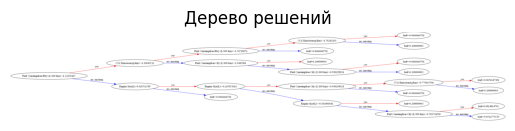

In [206]:
import matplotlib.pyplot as plt
from xgboost import plot_tree

plt.figure(figsize=(20, 12))
plot_tree(best_model, num_trees=0, rankdir='LR')
plt.title("Дерево решений")
plt.show()

### 5. Регрессия

С использованием GridSearchCV/grid_search осуществить подбор гиперпараметра модели линейной регрессии с использованием *XGBoost* или *CatBoost*.

In [207]:
target_reg = 'Fuel Type'
cat_features = df.select_dtypes(include=['object']).columns.tolist()
quant_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

le = LabelEncoder()
encoder = OneHotEncoder(sparse_output=False) 
data_encoded = df.copy()
categorical_cols = ['Transmission', 'Vehicle Class']
encoded_data = encoder.fit_transform(df[categorical_cols])
encoded_df = pd.DataFrame(
    encoded_data,
    columns=encoder.get_feature_names_out(categorical_cols),
    index=df.index
)

data_encoded = pd.concat([df.drop(categorical_cols, axis=1), encoded_df], axis=1)
data_encoded['Fuel Type'] = le.fit_transform(df['Fuel Type'])

# Разделение данных
X_encoded = data_encoded.drop(target_reg, axis=1)
y = data_encoded[target_reg]  # Используем Fuel Type как целевую переменную

X_train_enc, X_test_enc, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

# Настройка и обучение XGBoost регрессора
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', verbosity=0)

# Параметры для GridSearch
params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0, 0.1]
}

xgb_gs = GridSearchCV(xgb_reg, params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
xgb_gs.fit(X_train_enc, y_train)

# Лучшая модель
best_xgb_enc = xgb_gs.best_estimator_


Вывести метрики *MSE*, *MAE* и *R2* на тестовом наборе.

In [208]:
y_pred = best_xgb_enc.predict(X_test_enc)

print("XGBoost Regression (До фильтрации)")
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"R²: {r2_score(y_test, y_pred)}")
print("Лучшие параметры:", xgb_gs.best_params_)

XGBoost Regression (До фильтрации)
MSE: 0.04937054216861725
MAE: 0.1379586011171341
R²: 0.8970670700073242
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 0.1}


Переобучить модель на отфильтрованном наборе признаков из пункта 4.

In [209]:
X_train_filtered = X_train_enc[important_features]
X_test_filtered = X_test_enc[important_features]

# 4. Переобучаем модель на отобранных признаках
best_xgb_enc.fit(X_train_filtered, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [210]:
y_pred_filtered = best_xgb_enc.predict(X_test_filtered)

print("XGBoost Regression (После фильтрации)")
print(f"MSE: {mean_squared_error(y_test, y_pred_filtered)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_filtered)}")
print(f"R²: {r2_score(y_test, y_pred_filtered)}")
print("Лучшие параметры:", xgb_gs.best_params_)

XGBoost Regression (После фильтрации)
MSE: 0.08190695941448212
MAE: 0.19213970005512238
R²: 0.8292316794395447
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 0.1}


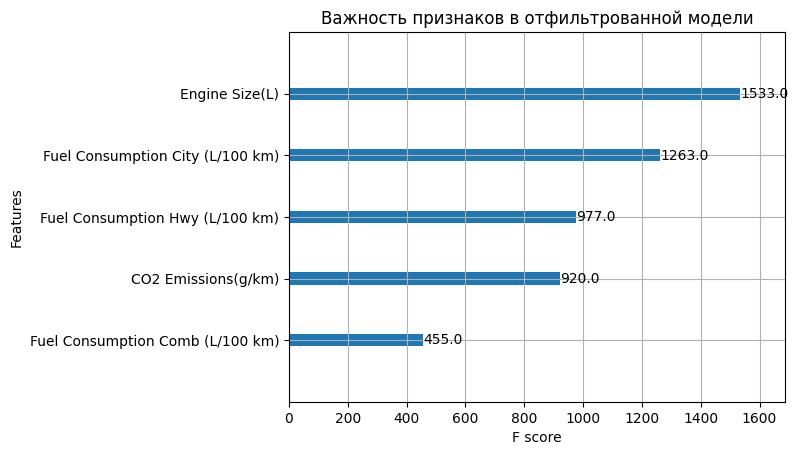

In [211]:
xgb.plot_importance(best_xgb_enc, importance_type='weight')
plt.title('Важность признаков в отфильтрованной модели')
plt.show()

Сравнить метрики до и после фильтрации.

После фильтрации признаков произошло падение качества модели:

1. MSE увеличилось в 1,67 раз (с 0.049 до 0.0819)
2. R² упал с 0.897 до 0.829
3. MAE вырос в 1,39 раз (с 0,138 до 0,192)
